In [1]:
import os
from tqdm import tqdm

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import pandas as pd
import numpy as np

from datetime import datetime

from statsmodels.graphics.tsaplots import plot_pacf

from sklearn.model_selection import StratifiedGroupKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score as roc_auc

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from xgboost import XGBClassifier as XGB

import warnings
warnings.filterwarnings("ignore")


SEED = 42

In [2]:
# ---- PALETTE ------------------------------------------------------
PALETTE_HEATMAP = ['#5f5f47', '#8d8d7c', '#d3d3c5', '#f1f1f1', '#f1f1f1', '#d3d3c5', '#8d8d7c', '#5f5f47']
PALETTE = ['#7eb0d5','#fd7f6f', '#b2e061','#bd7ebe','#ffb55a','#ffee65','#beb9db','#fdcce5','#8bd3c7']

DEFAULT_FONT_COLOR = '#909090'

# remove spines
for s in ['top', 'bottom', 'left', 'right']:
    mpl.rcParams[f'axes.spines.{s}'] = False

# ax 
mpl.rcParams['axes.grid'] = False
mpl.rcParams['axes.labelcolor'] = DEFAULT_FONT_COLOR
mpl.rcParams['axes.labelsize'] = 'small'
mpl.rcParams['axes.prop_cycle'] = mpl.cycler('color', PALETTE)
mpl.rcParams['axes.titlelocation'] = 'left'
mpl.rcParams['axes.titlesize'] = 18
mpl.rcParams['axes.titleweight'] = 'bold'
mpl.rcParams['axes.titlecolor'] = DEFAULT_FONT_COLOR

mpl.rcParams['font.size'] = 10

mpl.rcParams['grid.alpha'] = 0.3
mpl.rcParams['grid.color'] = DEFAULT_FONT_COLOR
mpl.rcParams['grid.linestyle'] = '--'

mpl.rcParams['text.color'] = DEFAULT_FONT_COLOR
mpl.rcParams['xtick.color'] = DEFAULT_FONT_COLOR
mpl.rcParams['ytick.color'] = DEFAULT_FONT_COLOR
mpl.rcParams['figure.facecolor'] = 'white'

mpl.rcParams['xtick.major.size'] = 0             # major tick size in points
mpl.rcParams['xtick.minor.size'] = 0             # minor tick size in points
mpl.rcParams['ytick.major.size'] = 0
mpl.rcParams['ytick.minor.size'] = 0

mpl.rcParams['legend.frameon'] = False



# ---- TEXT ACCENTS COLORS --------------------------------------------

# uncomment to print all 256 possible colors
# for i in range(0, 16):
#     for j in range(0, 16):
#         code = str(i * 16 + j)
#         print(u"\u001b[48;5;" + code + "m " + code.ljust(4), end=' ')
#     print (u"\u001b[0m")
    
TXT_BOLD = '\u001b[1m'
TXT_FOREGROUND = '\u001b[38;5;{}m'.format(254)
TXT_BACKGROUND = '\u001b[48;5;{}m'.format(240)

TXT_RESET = '\u001b[0m'

TXT_ACC = TXT_BOLD + TXT_FOREGROUND + TXT_BACKGROUND

print(f'\n\n{TXT_ACC} Accented text {TXT_RESET} Normal text\n')




# ---- REPRODICIBILITY ------------------------------------------------
np.random.seed(SEED)



# ---- PANDAS ---------------------------------------------------------
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:,.4f}'.format



 Accented text  Normal text



In [3]:
def CreateCorrelationHeatmap(cormatrix, ax):
    mask = np.eye(len(cormatrix)) # mask out identity correlations    
    heatmap = sns.heatmap(cormatrix, mask=mask, vmin=-1, vmax=1, annot_kws={'alpha': 0.5}, ax=ax,
                          annot=True, cmap=sns.color_palette(PALETTE_HEATMAP), cbar=False)
    heatmap.set_title('Feature correlations');
            
    # if feature name is long, rotate it for x-axis
    for label in heatmap.get_xticklabels():
#         if len(label.get_text()) > 5:
        label.set_rotation(90)
            
    # only horizontal y labels
    for label in heatmap.get_yticklabels():
        label.set_rotation(0)
            
    return heatmap

            
def CreateCorrelationWithTarget(cortarget, ax, need_title=True):
    heattarget = sns.heatmap(cortarget, vmin=-1, vmax=1, annot_kws={'alpha': 0.5}, ax=ax,
                              annot=True, cmap=sns.color_palette(PALETTE_HEATMAP), cbar=False)
    if need_title:
        heattarget.set_title('Correlation to target', loc='right');  
        
    # only horizontal labels
    for label in heattarget.get_yticklabels():
            label.set_rotation(0)
            
    return heattarget
        
def GetFeatureCorrelationsNonTarget(cormatrix):
    return cormatrix.iloc[:-1, :-1]


def GetCorrelationsWithTarget(cormatrix, target_feature):
    return cormatrix.iloc[:-1, -1:].sort_values(target_feature, key=lambda x: abs(x), ascending=False)
          
    
def GetHighlyCorrelatedFeatures(cormatrix):
    highly_cor_features = []
    for i, feature in enumerate(cormatrix.index):
        if np.any(abs(cormatrix[feature][: i]) > 0.5) or np.any(abs(cormatrix[feature][i + 1:]) > 0.5):
            highly_cor_features.append(feature)
    return highly_cor_features


def GetHighlyCorrelatedFeaturePairs(cormatrix):
    return [(cormatrix.index[x],cormatrix.index[y], cormatrix.iloc[x, y]) for (x,y) in 
                list(zip(*np.where(abs(cormatrix.values) > 0.5))) if x > y]


def DisplayCorrelations(cormatrix, target_feature):
    fig, axes = plt.subplots(1, 2, figsize=((cormatrix.shape[1] + 1) * 1.1  + 1, cormatrix.shape[1] * 0.4 + 1), 
                             gridspec_kw={'width_ratios': [cormatrix.shape[1], 1]})
    CreateCorrelationHeatmap( GetFeatureCorrelationsNonTarget(cormatrix), axes[0] )
    CreateCorrelationWithTarget( GetCorrelationsWithTarget(cormatrix, target_feature), axes[1] )
    
    plt.tight_layout(w_pad=5)    
    plt.show()

In [4]:
DIR = 'COVID-19-Wearables'
files = os.listdir(DIR)
N = 5
print(f'There are {len(files)} in the data folder. \nFirst {N} filenames are:')
print(files[:N])

There are 280 in the data folder. 
First 5 filenames are:
['A06L7KF_hr.csv', 'A06L7KF_steps.csv', 'A0822M0_hr.csv', 'A0822M0_steps.csv', 'A0KX894_hr.csv']


In [5]:
files_not_csv = []
for file in files:
    if not file.endswith('.csv'):
        files_not_csv.append(file)
        
print(f'There are {len(files_not_csv)} files that are not *.csv')

There are 0 files that are not *.csv


In [6]:
cols = []
min_time = []
max_time = []
num_times = []
for file in tqdm(files):
    df = pd.read_csv(os.path.join(DIR, file), parse_dates=['datetime'])
    cols.append(df.columns.values)
    min_time.append(df['datetime'].min())
    max_time.append(df['datetime'].max())
    num_times.append(df.shape[0])

100%|████████████████████████████████████████████████████████████████████████████████| 280/280 [03:02<00:00,  1.53it/s]


In [7]:
substrs = [f.split('_') for f in files]

ids = [s[0] for s in substrs]
datatypes = ['_'.join(s[1:])[:-4] for s in substrs]

In [8]:
df_files = pd.DataFrame(np.vstack([files, ids, datatypes, cols, num_times, min_time, max_time]).T,
                       columns=['filename', 'id', 'datatype', 'columns', 'count_samples', 'start', 'end'])
df_files['span'] = df_files['end'] - df_files['start']
df_files

,filename,id,datatype,columns,count_samples,start,end,span
0,A06L7KF_hr.csv,A06L7KF,hr,"[user, datetime, heartrate]",100569,2023-08-22 00:00:00,2023-11-22 16:43:00,92 days 16:43:00
1,A06L7KF_steps.csv,A06L7KF,steps,"[user, datetime, steps]",57540,2023-08-22 00:00:00,2023-09-30 23:59:00,39 days 23:59:00
2,A0822M0_hr.csv,A0822M0,hr,"[user, datetime, heartrate]",731892,2026-06-08 00:00:03,2026-08-15 23:58:57,68 days 23:58:54
3,A0822M0_steps.csv,A0822M0,steps,"[user, datetime, steps]",99300,2026-06-08 00:00:00,2026-08-15 23:59:00,68 days 23:59:00
4,A0KX894_hr.csv,A0KX894,hr,"[user, datetime, heartrate]",879561,2026-07-22 00:00:04,2026-10-22 23:58:56,92 days 23:58:52
...,...,...,...,...,...,...,...,...
275,AZIK4ZA_hr.csv,AZIK4ZA,hr,"[user, datetime, heartrate]",738941,2024-11-05 00:00:01,2025-01-15 23:57:11,71 days 23:57:10
276,AZIK4ZA_sleep.csv,AZIK4ZA,sleep,"[user, datetime, stage_duration, stage]",2414,2024-11-04 23:12:00,2025-02-03 06:57:30,90 days 07:45:30
277,AZIK4ZA_steps.csv,AZIK4ZA,steps,"[user, datetime, steps]",103680,2024-11-05 00:00:00,2025-01-15 23:59:00,71 days 23:59:00
278,AZKZ0AI_hr.csv,AZKZ0AI,hr,"[user, datetime, heartrate]",803334,2024-02-12 00:00:00,2024-05-13 17:49:54,91 days 17:49:54


In [9]:
df_files['id'].value_counts().to_frame()

,id
AA0HAI1,6
ASFODQR,5
AJWW3IY,5
AAXAA7Z,5
AIFDJZB,5
...,...
AEOBCFJ,2
AE2B3RH,2
AE0MQ94,2
AD77K91,2


In [10]:
df_files['datatype'].value_counts().to_frame()

,datatype
hr,117
steps,117
sleep,32
hr_longterm,4
steps_longterm,4
1_hr,1
1_steps,1
2_hr,1
2_steps,1
3_hr,1


In [11]:
ext_rarest = df_files['datatype'].value_counts()[-8:]
df_files.loc[df_files['datatype'].isin(ext_rarest.index)]

,filename,id,datatype,columns,count_samples,start,end,span
77,AA0HAI1_1_hr.csv,AA0HAI1,1_hr,"[user, datetime, heartrate]",400990,2029-06-05 09:03:56,2029-09-03 21:30:13,90 days 12:26:17
78,AA0HAI1_1_steps.csv,AA0HAI1,1_steps,"[user, datetime, steps]",129540,2029-06-05 00:00:00,2029-09-03 23:59:00,90 days 23:59:00
79,AA0HAI1_2_hr.csv,AA0HAI1,2_hr,"[user, datetime, heartrate]",398689,2029-07-11 00:00:00,2029-10-09 23:58:54,90 days 23:58:54
80,AA0HAI1_2_steps.csv,AA0HAI1,2_steps,"[user, datetime, steps]",130980,2029-07-11 00:00:00,2029-10-09 23:59:00,90 days 23:59:00
81,AA0HAI1_3_hr.csv,AA0HAI1,3_hr,"[user, datetime, heartrate]",324091,2030-06-22 00:00:09,2030-09-03 23:58:57,73 days 23:58:48
82,AA0HAI1_3_steps.csv,AA0HAI1,3_steps,"[user, datetime, steps]",106500,2030-06-22 00:00:00,2030-09-03 23:59:00,73 days 23:59:00
91,AAXAA7Z_hr_longterm.csv,AAXAA7Z,hr_longterm,"[user, datetime, heartrate]",4633367,2022-01-18 00:00:06,2023-04-18 23:58:57,455 days 23:58:51
94,AAXAA7Z_steps_longterm.csv,AAXAA7Z,steps_longterm,"[user, datetime, steps]",656520,2022-01-18 00:00:00,2023-04-18 23:59:00,455 days 23:59:00
138,AIFDJZB_hr_longterm.csv,AIFDJZB,hr_longterm,"[user, datetime, heartrate]",4572912,2022-08-09 00:00:02,2024-01-15 23:58:54,524 days 23:58:52
141,AIFDJZB_steps_longterm.csv,AIFDJZB,steps_longterm,"[user, datetime, steps]",702624,2022-08-09 00:00:00,2024-01-15 23:59:00,524 days 23:59:00


### Insights:

All save one unique IDs have corresponding *heart rates* and *steps*.

One ID has 3 separate measurements for *heart rate* and *steps*: **AA0HAI1**

Four IDs have additional longterm measurments of *heart rate* and *steps*.

Some IDs have *sleep* measurments.

In [12]:
df_sickness = pd.read_excel('41551_2020_640_MOESM3_ESM.xlsx', sheet_name='SuppTable4_Fig2a_Illnesses') \
    .drop([0,1,2,3], axis=0) \
    .reset_index(drop=True) \
    .iloc[:,:3]
df_sickness.columns = ['id', 'sick_start', 'sick_end']

df_sickness

,id,sick_start,sick_end
0,AOYM4KG,2022-11-14 00:00:00,2023-05-29 00:00:00
1,AOYM4KG,2023-07-04 00:00:00,2023-08-01 00:00:00
2,AOYM4KG,2023-08-29 00:00:00,2023-09-19 00:00:00
3,AOYM4KG,2023-10-24 00:00:00,2023-11-09 00:00:00
4,AR4FPCC,2027-02-16 00:00:00,2027-02-20 00:00:00
5,AR4FPCC,2027-04-11 00:00:00,2027-05-01 00:00:00
6,AUILKHG,2027-07-18 00:00:00,NaN
7,AD77K91,2023-09-04 00:00:00,2023-09-19 00:00:00
8,AX6281V,2024-01-13 00:00:00,2024-01-21 00:00:00
9,AX6281V,2024-02-08 00:00:00,2024-02-18 00:00:00


In [13]:
print(f'Number of IDs with reported sickness periods: {df_sickness["id"].nunique()}') 

Number of IDs with reported sickness periods: 18


In [14]:
df_anomalies_covid = pd.read_excel('41551_2020_640_MOESM3_ESM.xlsx', sheet_name='SuppTable7_COVIDanomaliesHROSAD') \
    .drop([0,1,2], axis=0) \
    .reset_index(drop=True)
df_anomalies_covid.columns = ['id', 'datetime', 'val']

df_anomalies_all = pd.read_excel('41551_2020_640_MOESM3_ESM.xlsx', sheet_name='SuppTable8_AllDetAnomRHR-AD') \
    .drop([0,1,2], axis=0) \
    .reset_index(drop=True)
df_anomalies_all.columns = ['id', 'datetime', 'val']

df_anomalies_all.head()

,id,datetime,val
0,A0KX894,2026-08-01 07:00:00,1.4815
1,A0KX894,2026-08-01 08:00:00,1.5100
2,A0KX894,2026-08-01 09:00:00,1.5327
3,A0KX894,2026-08-01 13:00:00,1.5623
4,A0KX894,2026-08-01 14:00:00,1.5908


In [15]:
print(f'Number of IDs with COVID anomalies: {df_anomalies_covid["id"].nunique()}') 
print(f'Number of IDs with general anomalies: {df_anomalies_all["id"].nunique()}') 
print()
print(f'Total number of COVID anomalies: {df_anomalies_covid.shape[0]}')
print(f'Total number of general anomalies: {df_anomalies_all.shape[0]}')

Number of IDs with COVID anomalies: 32
Number of IDs with general anomalies: 44

Total number of COVID anomalies: 2883
Total number of general anomalies: 2872


In [16]:
count_datapoints = 0
for idx in df_files['id'].unique():
    files = df_files.query(f'id == "{idx}" & datatype == "hr"')['filename']
    if files.shape[0] > 0:
        count_datapoints += pd.read_csv(os.path.join(DIR, files.iloc[0])).shape[0]
    else:
        print('Bad ID:', idx)
print(f'Approximate number of datapoints: {count_datapoints}')

Bad ID: AA0HAI1
Approximate number of datapoints: 72078070


## Generate metadata plots

In [17]:
period = 'D'

for idx in tqdm(df_files['id'].unique()):


    # get all files for current ID
    df_files_current = df_files.query(f'id == "{idx}"')[['filename', 'datatype']]
    if df_files_current.shape[0] > 2:
        df_files_current = df_files_current.iloc[[0,2,1],:] # reorder so that sleep is last

    # get COVID anomalies
    df_covid = df_anomalies_covid.query(f'id == "{idx}"')
    if df_covid.shape[0] > 0: # if there are anomalies -> resample
        df_covid = df_covid.set_index('datetime').resample(rule=period).sum()
        df_covid = df_covid.loc[df_covid['val'] > 0]

    # get all anomalies
    df_sick = df_anomalies_all.query(f'id == "{idx}"')
    if df_sick.shape[0] > 0:
        df_sick = df_sick.set_index('datetime').resample(rule=period).sum()
        df_sick = df_sick.loc[df_sick['val'] > 0]


    plt.figure(figsize=(10, 2*df_files_current.shape[0]))


    for i, (file, datatype) in enumerate(df_files_current.values):
        df = pd.read_csv(os.path.join(DIR, file), parse_dates=['datetime']) \
            .set_index('datetime') \
            .resample(rule=period) \
            .sum() 
        df /= df.max()
        df -= i+1
        plt.plot(df.index, df.iloc[:,-1], color='gray')    

        plt.text(df.index.min(), df.iloc[0,-1], (datatype if datatype != 'hr' else 'heart\nrate') + '  ', ha='right', size=14)

        # some intervals are outside of the main dates
        try:
            plt.scatter(df_sick.index, df.loc[df_sick.index].iloc[:,-1], color='blue', alpha=0.3, marker='o', s=100, label='all\nanomalies' if i == 0 else '')
            plt.scatter(df_covid.index, df.loc[df_covid.index].iloc[:,-1], color='red', marker='x', label='covid\nanomalies' if i == 0 else '')
        except:
            pass

    # plot sickness period
    for i, row in df_sickness.query(f'id == "{idx}"').iterrows():
        if type(row['sick_end']) is datetime:
            plt.axvspan(row['sick_start'], row['sick_end'], alpha=0.1, color='gray', label='illness' if i==0 else '')


    plt.title(idx)
    plt.yticks([])
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.tight_layout()

    plt.savefig(f'img/{idx}.png')
    plt.close()
# plt.show();

 14%|███████████▋                                                                     | 17/118 [00:22<01:57,  1.16s/it]posx and posy should be finite values
posx and posy should be finite values
100%|████████████████████████████████████████████████████████████████████████████████| 118/118 [03:00<00:00,  1.53s/it]


## *Heart rate* and *steps* processing

### AA0HAI1 and longterm signals

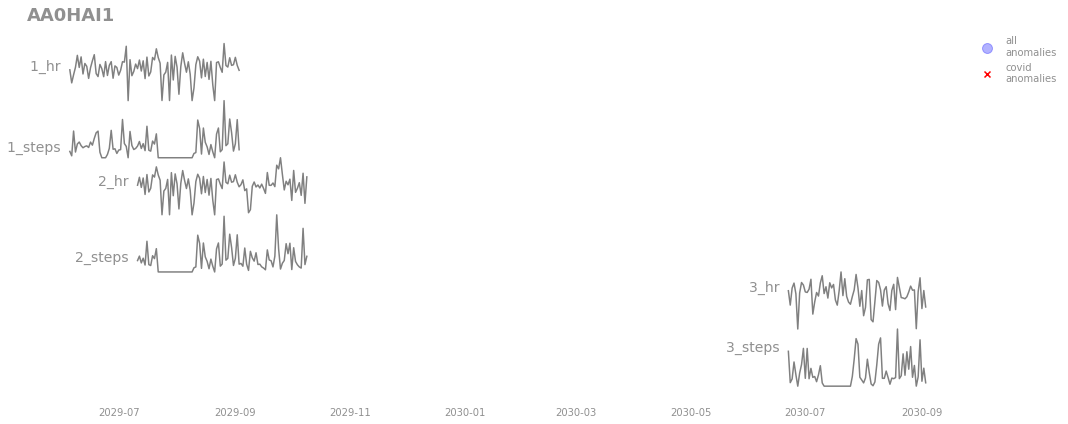

In [18]:
idx = 'AA0HAI1'
df_files_current = df_files.query(f'id == "{idx}"')[['filename', 'datatype']]

# get COVID anomalies
df_covid = df_anomalies_covid.query(f'id == "{idx}"')
if df_covid.shape[0] > 0: # if there are anomalies -> resample
    df_covid = df_covid.set_index('datetime').resample(rule=period).sum()
    df_covid = df_covid.loc[df_covid['val'] > 0]

# get all anomalies
df_sick = df_anomalies_all.query(f'id == "{idx}"')
if df_sick.shape[0] > 0:
    df_sick = df_sick.set_index('datetime').resample(rule=period).sum()
    df_sick = df_sick.loc[df_sick['val'] > 0]

plt.figure(figsize=(15, df_files_current.shape[0]))

for i, (file, datatype) in enumerate(df_files_current.values):
    df = pd.read_csv(os.path.join(DIR, file), parse_dates=['datetime']) \
        .set_index('datetime') \
        .resample(rule=period) \
        .sum() 
    df /= df.max()
    df -= i+1
    plt.plot(df.index, df.iloc[:,-1], color='gray')   
    plt.text(df.index.min(), df.iloc[0,-1], (datatype if datatype != 'hr' else 'heart\nrate') + '  ', ha='right', size=14)
    
    plt.scatter(df_sick.index, df.loc[df_sick.index].iloc[:,-1], color='blue', alpha=0.3, marker='o', s=100, label='all\nanomalies' if i == 0 else '')
    plt.scatter(df_covid.index, df.loc[df_covid.index].iloc[:,-1], color='red', marker='x', label='covid\nanomalies' if i == 0 else '')

    
plt.title(idx)
plt.yticks([])
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()

AA0HAI1 can be dropped -- there are no anomalies, steps data has blanks in all periods.

Also all longterm additional files can be dropped -- anomalies are detected within bounds of regular *hr* and *steps* records.

Drop sleep.

In [19]:
df_files = df_files.drop(df_files.query(f'id == "AA0HAI1"').index, axis=0)
df_files = df_files.drop(df_files.query(f'datatype.str.contains("longterm")').index, axis=0)
df_files = df_files.drop(df_files.query(f'datatype.str.contains("sleep")').index, axis=0)
print(df_files.shape[0], 'files')

234 files


For each ID create a dataframe with *steps* and *hr* signals

# Example

In [20]:
period = 'D'

idx = 'AZIK4ZA'
# idx = 'AYWIEKR'
# idx = 'AYEFCWQ'

df_hr = pd.read_csv(os.path.join(DIR, idx + '_hr.csv'), parse_dates=['datetime'])
df_steps = pd.read_csv(os.path.join(DIR, idx + '_steps.csv'), parse_dates=['datetime'])

df = pd.merge(df_hr, df_steps) \
    .set_index('datetime') \
    .resample(rule=period) \
    .agg({'steps': 'sum',
          'heartrate': ['mean', 'std', 'min', 'max']})
df.columns = ['steps', 'hr_mean', 'hr_std', 'hr_min', 'hr_max']

scaler = StandardScaler()
df = pd.DataFrame(scaler.fit_transform(df), index=df.index, columns=df.columns)

df = df.dropna(axis=0)
    
df['hr_mean/steps'] = df['hr_mean'] / df['steps']
df['steps/hr_mean'] = df['steps'] / df['hr_mean']
df['steps*hr_mean'] = df['steps'] * df['hr_mean']

df_sick = df_anomalies_all.query(f'id == "{idx}"')
if df_sick.shape[0] > 0:
    df_sick = df_sick.set_index('datetime').resample(rule=period).sum()
    df_sick = df_sick.loc[df_sick['val'] > 0]

df['is_anomalie'] = 0
df.loc[df_sick.index, 'is_anomalie'] = 1

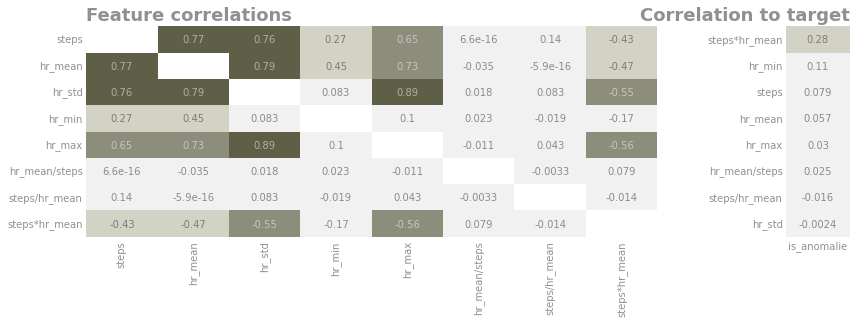

In [21]:
DisplayCorrelations(df.corr(), 'is_anomalie')

# Partial autocorrelation

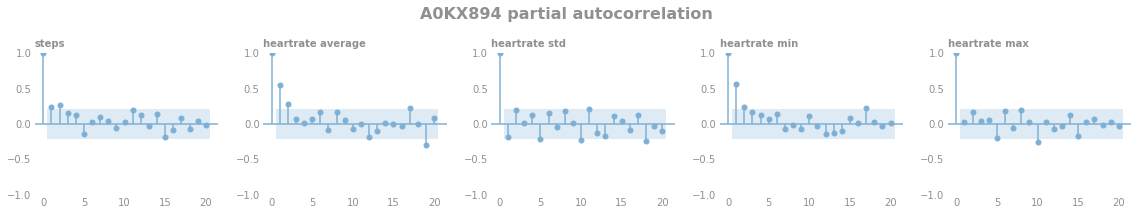

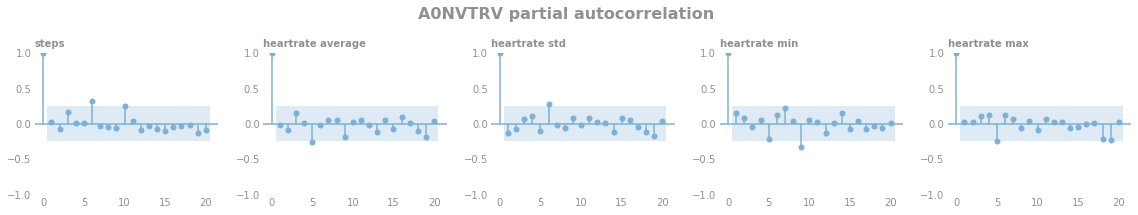

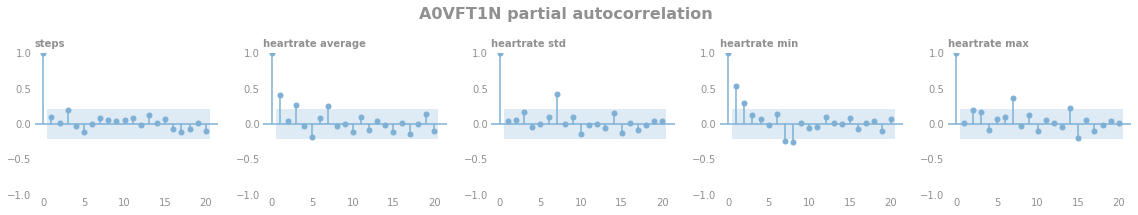

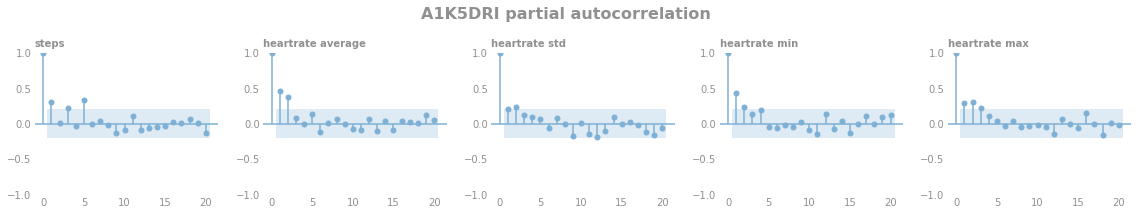

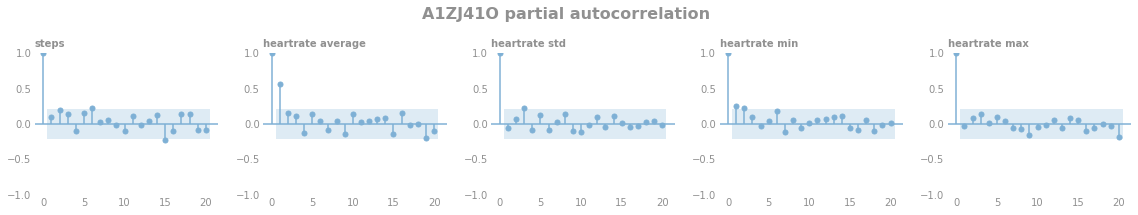

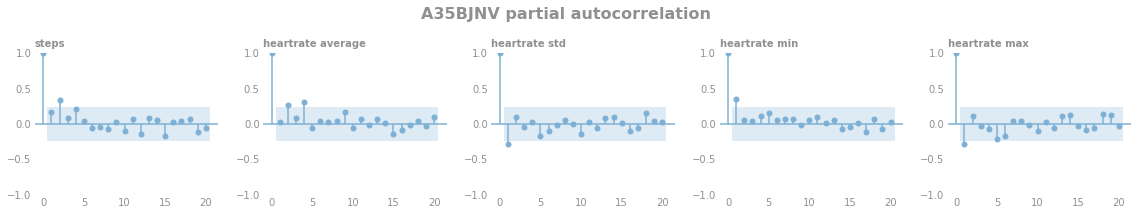

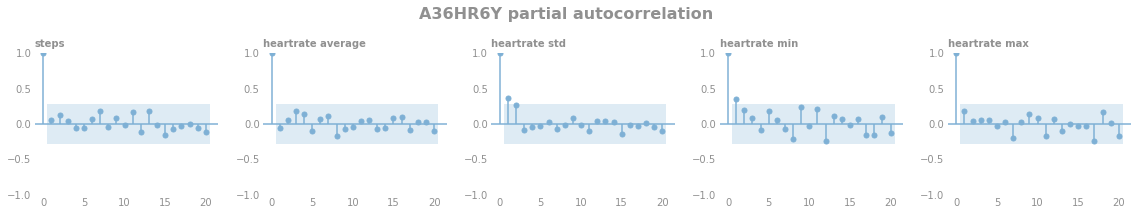

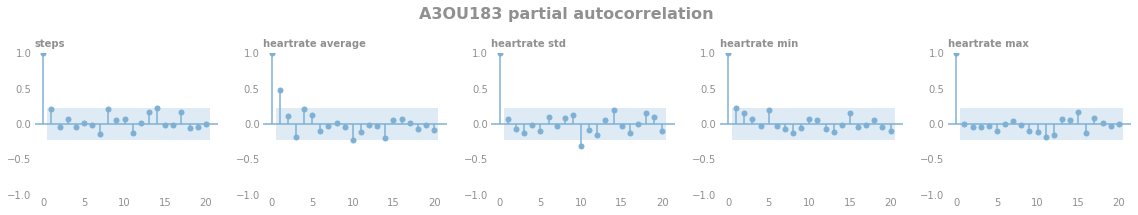

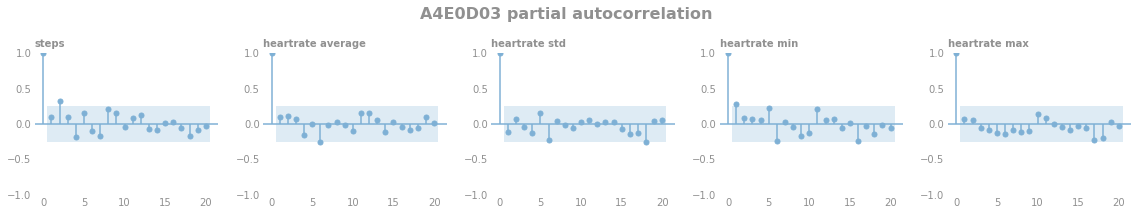

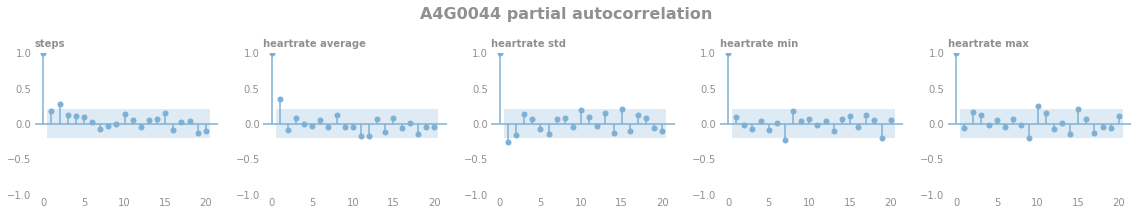

In [22]:
period = 'D'

for idx in df_anomalies_all['id'].unique()[:10]:

    df_hr = pd.read_csv(os.path.join(DIR, idx + '_hr.csv'), parse_dates=['datetime'])
    df_steps = pd.read_csv(os.path.join(DIR, idx + '_steps.csv'), parse_dates=['datetime'])

    df = pd.merge(df_hr, df_steps) \
        .set_index('datetime') \
        .resample(rule=period) \
        .agg({'steps': 'sum',
              'heartrate': ['mean', 'std', 'min', 'max']})
    df.columns = ['steps', 'hr_mean', 'hr_std', 'hr_min', 'hr_max']   
    df = df.dropna(axis=0)
    
    scaler = StandardScaler()
    df = pd.DataFrame(scaler.fit_transform(df), index=df.index, columns=df.columns)
    
    _, axes = plt.subplots(ncols=5, nrows=1, figsize=(16, 3))

    plt.suptitle(idx + ' partial autocorrelation', fontsize=16, fontweight='bold')
    plot_pacf(df['steps'], lags=20, ax=axes[0], method='ywm')
    plot_pacf(df['hr_mean'], lags=20, ax=axes[1], method='ywm')
    plot_pacf(df['hr_std'], lags=20, ax=axes[2], method='ywm')
    plot_pacf(df['hr_min'], lags=20, ax=axes[3], method='ywm')
    plot_pacf(df['hr_max'], lags=20, ax=axes[4], method='ywm')
    axes[0].set_title('steps', fontsize=10)
    axes[1].set_title('heartrate average', fontsize=10)
    axes[2].set_title('heartrate std', fontsize=10)
    axes[3].set_title('heartrate min', fontsize=10)
    axes[4].set_title('heartrate max', fontsize=10)
    plt.tight_layout()
    plt.show()

In [23]:
n_lags = 10

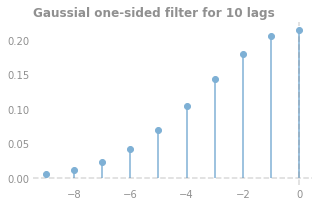

In [24]:
sigma = n_lags / 3
xaxis = range(-n_lags+1,1)
filter_gauss = [np.exp(-x**2/(2*sigma**2)) for x in xaxis]
filter_gauss /= sum(filter_gauss)

plt.figure(figsize=(5, 3))
plt.axhline(0, linestyle='--', color='gray', alpha=0.3)
plt.axvline(0, linestyle='--', color='gray', alpha=0.3)
plt.stem(xaxis, filter_gauss, basefmt=' ')
plt.title(f'Gaussial one-sided filter for {n_lags} lags', fontsize=12)
plt.show();

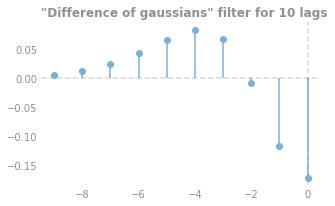

In [25]:
sigma2 = sigma / 2
xaxis = range(-n_lags+1,1)
filter_gauss2 = np.array([np.exp(-x**2/(2*sigma2**2)) for x in xaxis])
filter_gauss2 /= filter_gauss2.sum()

filter_gauss_dif = filter_gauss - filter_gauss2

plt.figure(figsize=(5, 3))
plt.axhline(0, linestyle='--', color='gray', alpha=0.3)
plt.axvline(0, linestyle='--', color='gray', alpha=0.3)
plt.stem(xaxis, filter_gauss_dif, basefmt=' ')
plt.title(f'"Difference of gaussians" filter for {n_lags} lags', fontsize=12)
plt.show();

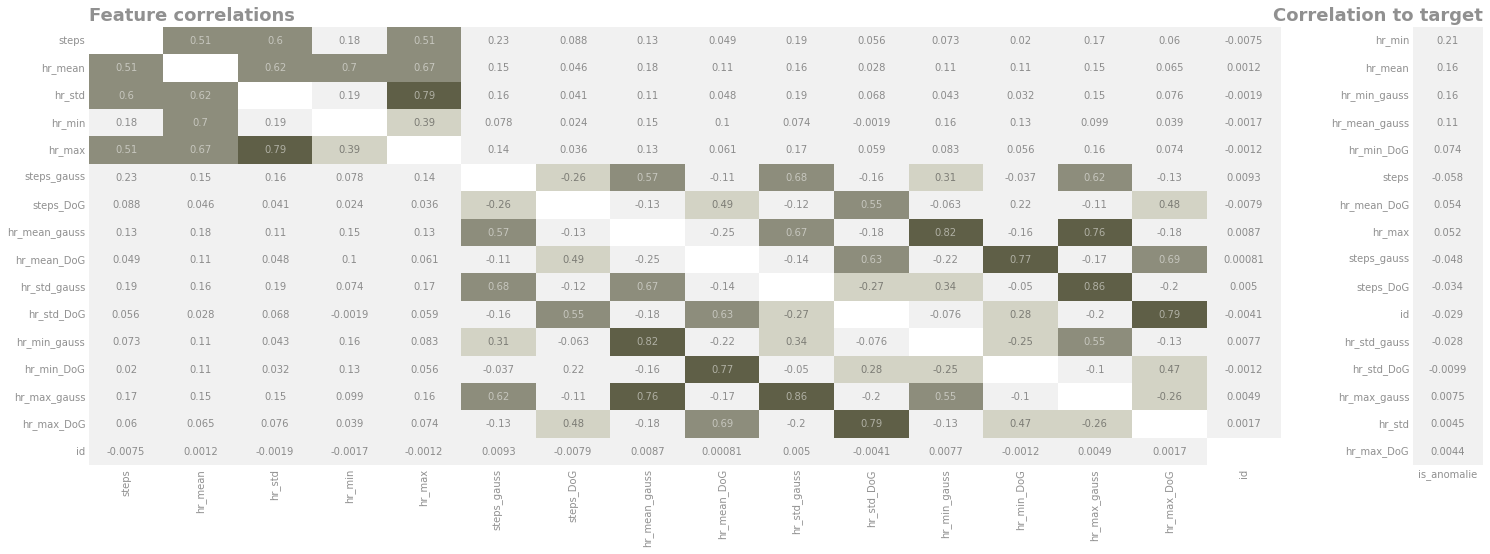

Wall time: 57.8 s


In [26]:
%%time

period = 'D'

df_train = pd.DataFrame()

for i, idx in enumerate(df_anomalies_all['id'].unique()):

    df_hr = pd.read_csv(os.path.join(DIR, idx + '_hr.csv'), parse_dates=['datetime'])
    df_steps = pd.read_csv(os.path.join(DIR, idx + '_steps.csv'), parse_dates=['datetime'])

    df = pd.merge(df_hr, df_steps) \
        .set_index('datetime') \
        .resample(rule=period) \
        .agg({'steps': 'sum',
              'heartrate': ['mean', 'std', 'min', 'max']})
    df.columns = ['steps', 'hr_mean', 'hr_std', 'hr_min', 'hr_max']
    
    # after resampling empty rows may appear if there were gaps
    df = df.fillna(0)
    
    scaler = StandardScaler()
    df = pd.DataFrame(scaler.fit_transform(df), index=df.index, columns=df.columns)

    for feature in df.columns:
        gauss = np.convolve(df[feature], filter_gauss, mode='valid')
        DoG = np.convolve(df[feature], filter_gauss_dif, mode='valid')
        df[f'{feature}_gauss'] = 0
        df[f'{feature}_gauss'].iloc[n_lags-1:] = gauss
        df[f'{feature}_DoG'] = 0
        df[f'{feature}_DoG'].iloc[n_lags-1:] = DoG

    df = df.drop(df.iloc[:n_lags-1,:].index, axis=0)

    df_sick = df_anomalies_all.query(f'id == "{idx}"')
    if df_sick.shape[0] > 0:
        df_sick = df_sick.set_index('datetime').resample(rule=period).sum()
        df_sick = df_sick.loc[df_sick['val'] > 0]
        index = [v for v in df_sick.index if v in df.index]
        df_sick = df_sick.loc[index]
            
    df['id'] = i # for stratification
            
    df['is_anomalie'] = 0
    df.loc[df_sick.index, 'is_anomalie'] = 1
    
    df_train = pd.concat([df_train, df], axis=0)

DisplayCorrelations(df_train.corr(), 'is_anomalie')

In [27]:
df_train['is_anomalie'].value_counts() / df_train.shape[0]

0   0.8848
1   0.1152
Name: is_anomalie, dtype: float64

In [28]:
df_train = df_train.drop_duplicates()

In [29]:
y_train = df_train.pop('is_anomalie')
groups = df_train.pop('id')

In [30]:
N_FOLDS = 5
cv = StratifiedGroupKFold(n_splits=N_FOLDS, shuffle=True, random_state=SEED)

features = ['hr_min', 
            'hr_mean', 
            'hr_min_gauss', 
#             'hr_mean_gauss', 
            'hr_min_DoG', 
            'steps', 'steps_gauss',
#             'hr_std_gauss'
           ]

scores = []
preds_oof = []
vals = []

for fold, (train_idx, val_idx) in enumerate(cv.split(df_train, y_train, groups)):
    X = df_train.iloc[train_idx, :][features]
    Y = y_train.iloc[train_idx]
    X_val = df_train.iloc[val_idx, :][features]
    Y_val = y_train.iloc[val_idx]
    
    models = ( ('xgb', XGB(random_state=SEED, n_estimators=50, max_depth=4, learning_rate=0.05)),
               ('lr', LogisticRegression(class_weight='balanced')),
               ('svc', SVC(random_state=SEED, class_weight='balanced', probability=True, kernel='linear')),
               ('knn', KNeighborsClassifier(n_neighbors=100)),
             )
    
    scores_fold = []
    preds_fold = []
    for _, model in models:
        model.fit(X, Y)
        pred_oof = model.predict_proba(X_val)[:,1]       
        score = roc_auc(Y_val, pred_oof)
    
        scores_fold.append(score)
        preds_fold.append(pred_oof)
        
    # blend
    preds_fold.append(np.average(preds_fold, weights=[0.4, 0.2, 0.3, 0.1], axis=0))
    scores_fold.append(roc_auc(Y_val, preds_fold[-1]))
    
    vals.append(Y_val)
    scores.append(scores_fold)
    preds_oof.append(preds_fold)
    
    print(f'Fold {fold}:       ', end='')
    for i, (title,_) in enumerate(models):
        print(f'{title}   {scores_fold[i]:.3f} | ', end='')
    print(f'Blend   {scores_fold[-1]:.3f} | ', end='')    
    print()
    
preds_oof = np.array(preds_oof)
scores = np.array(scores)

print()
print(f'Average score xgb:       {scores.T[0].mean():.3f}')
print(f'Average score lr:        {scores.T[1].mean():.3f}')
print(f'Average score svc:       {scores.T[2].mean():.3f}')
print(f'Average score KNN:       {scores.T[3].mean():.3f}')
print(f'Average score ensemble:  {scores.T[4].mean():.3f}')

Fold 0:       xgb   0.732 | lr   0.748 | svc   0.754 | knn   0.706 | Blend   0.757 | 
Fold 1:       xgb   0.792 | lr   0.792 | svc   0.792 | knn   0.790 | Blend   0.808 | 
Fold 2:       xgb   0.772 | lr   0.738 | svc   0.732 | knn   0.705 | Blend   0.761 | 
Fold 3:       xgb   0.787 | lr   0.836 | svc   0.835 | knn   0.783 | Blend   0.830 | 
Fold 4:       xgb   0.694 | lr   0.636 | svc   0.642 | knn   0.675 | Blend   0.674 | 

Average score xgb:       0.755
Average score lr:        0.750
Average score svc:       0.751
Average score KNN:       0.732
Average score ensemble:  0.766


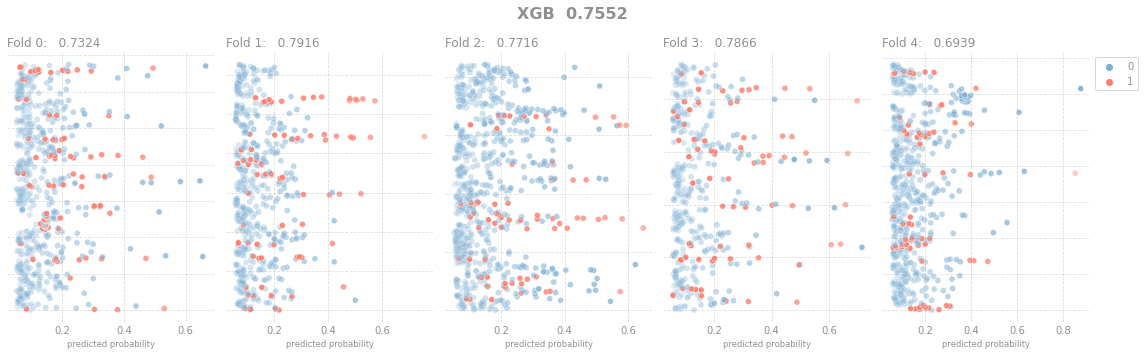

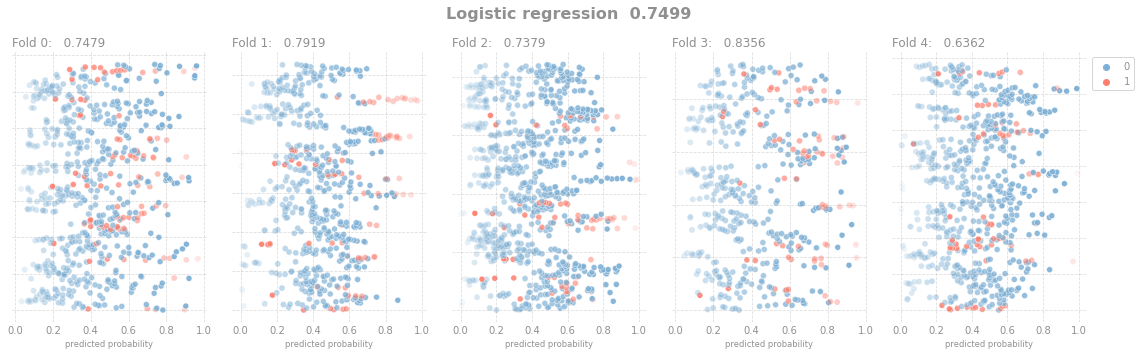

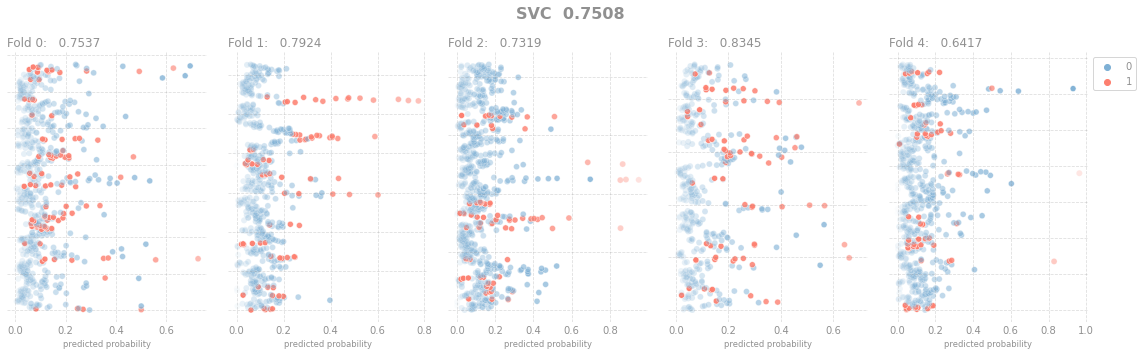

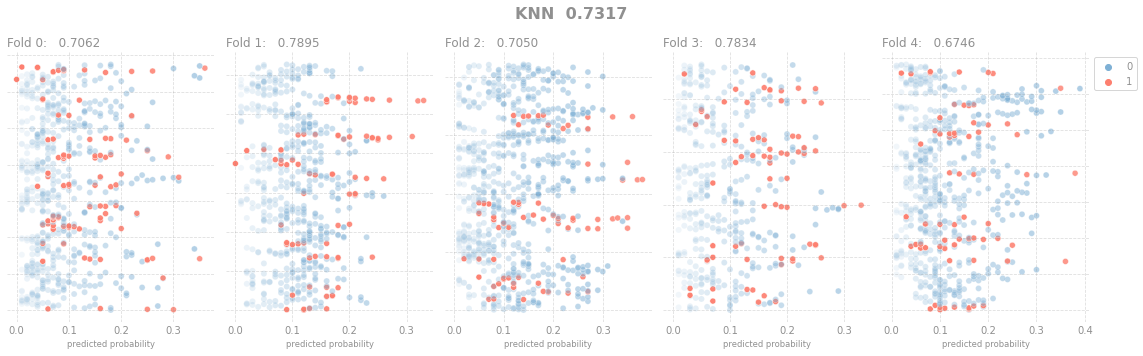

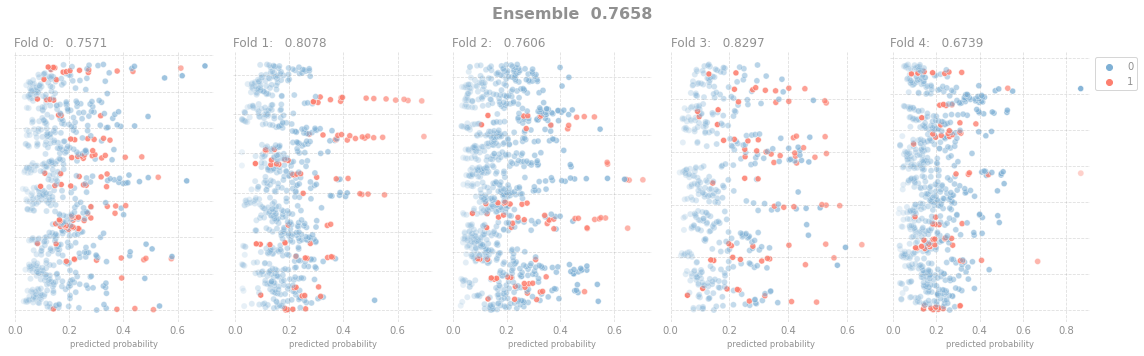

In [31]:
for i, title in enumerate(['XGB', 'Logistic regression', 'SVC', 'KNN', 'Ensemble']):

    _, axes = plt.subplots(ncols=N_FOLDS, nrows=1, figsize=(16, 5))
    axes = axes.ravel()
    sc = None
    for fold, (pred, val, ax, score) in enumerate(zip(preds_oof.T[i], vals, axes, scores.T[i])):
        ax.set_title(f'Fold {fold}:   {score:.4f}', fontsize=12, fontweight='normal')
        
        sns.scatterplot(x=pred, y=np.arange(len(val.index)), hue=val, ax=ax, legend=(fold == len(vals)-1), alpha=abs(val.values - pred)**0.5)
        if fold == len(vals)-1:
            ax.legend(loc='upper left', bbox_to_anchor=(1, 1), frameon=True)
        
        ax.grid(True)
        ax.set_yticklabels([])
        ax.set_xlabel('predicted probability')
    
    plt.suptitle(f'{title}  {scores.T[i].mean():.4f}', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

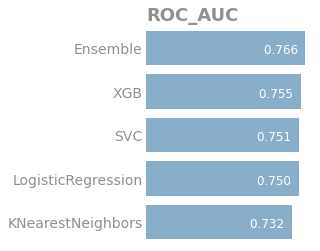

In [32]:
df_res = pd.DataFrame(scores.T, 
                      index=['XGB', 'LogisticRegression', 'SVC', 'KNearestNeighbors', 'Ensemble'],
                      columns=[f'Fold_{i}' for i in range(N_FOLDS)])
df_res['score'] = df_res.mean(axis=1)
df_res = df_res.sort_values('score', ascending=False)

plt.figure(figsize=(3,4))

ax = sns.barplot(y=df_res.index, 
                 x=df_res['score']**2, # make difference visually more obvious
                 orient='h',
                 color=PALETTE[0],
                )

plt.yticks(fontsize=14)
plt.xticks([])
plt.xlabel('')

plt.title('ROC_AUC')

for i, p in enumerate(ax.patches):
    width = p.get_width()
    plt.text(p.get_width(), p.get_y() + 0.55 * p.get_height(),
             '{:.3f}  '.format(df_res['score'][i]),
             ha='right', va='center', color='white', fontsize=12)

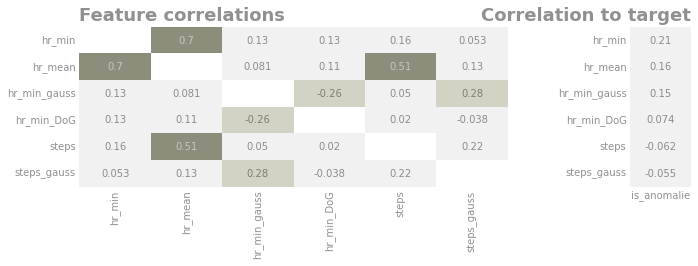

In [33]:
DisplayCorrelations(pd.concat([df_train[features], y_train], axis=1).corr(), 'is_anomalie')

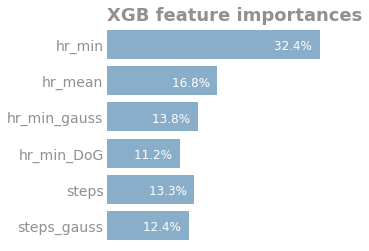

In [34]:
model = XGB(random_state=SEED, n_estimators=50, max_depth=4, learning_rate=0.05)
model.fit(df_train[features], y_train)

plt.figure(figsize=(4, 4))
ax = sns.barplot(y=features,
                 x=model.feature_importances_,
                 orient='h',
                 color=PALETTE[0],
                )

plt.yticks(fontsize=14)
plt.xticks([])
plt.xlabel('')

plt.title('XGB feature importances')

for i, p in enumerate(ax.patches):
    width = p.get_width()
    plt.text(p.get_width(), p.get_y() + 0.55 * p.get_height(),
             '{:.1f}%  '.format(model.feature_importances_[i] * 100),
             ha='right', va='center', color='white', fontsize=12)

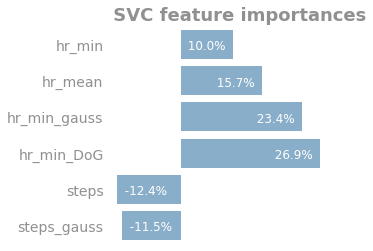

In [35]:
model = SVC(random_state=SEED, class_weight='balanced', probability=True, kernel='linear')
model.fit(df_train[features], y_train)

importances = model.coef_[0] / abs(model.coef_[0]).sum()

plt.figure(figsize=(4, 4))
ax = sns.barplot(y=features,
                 x=importances,
                 orient='h',
                 color=PALETTE[0],
                )

plt.yticks(fontsize=14)
plt.xticks([])
plt.xlabel('')

plt.title(' SVC feature importances')

for i, p in enumerate(ax.patches):
    width = p.get_width()
    plt.text(p.get_width(), p.get_y() + 0.55 * p.get_height(),
             '  {:.1f}%  '.format(importances[i] * 100),
             ha='left' if importances[i]<0 else 'right', va='center', color='white', fontsize=12)